In [1]:
import pathlib

import numpy as np
import pandas as pd;
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
df = pd.read_excel('./data/白酒板块股票收盘价.xlsx', header=1, index_col=0, skiprows=0).dropna()
tickers = df.columns
df.head()

,000568.SZ,600809.SH,600779.SH,603369.SH,600702.SH,002304.SZ,600197.SH,603589.SH,000860.SZ,600519.SH,000799.SZ,603198.SH,000858.SZ,600199.SH,002646.SZ,603919.SH,000596.SZ,600559.SH
Date,,,,,,,,,,,,,,,,,,
2016-03-10,22.12,15.94,9.92,27.39,16.60,66.30,12.00,29.78,18.78,228.06,13.73,19.08,25.14,7.43,16.18,15.75,33.00,49.82
2016-03-11,22.26,15.86,9.94,26.53,16.30,65.34,11.95,29.28,19.08,228.05,13.97,18.87,25.40,7.30,15.94,17.33,32.60,46.88
2016-03-14,22.54,16.25,10.22,27.38,17.09,64.27,12.19,30.04,19.30,224.57,14.18,19.44,25.45,7.51,17.53,19.06,32.58,48.17
2016-03-15,22.61,16.18,10.39,26.90,17.14,63.20,11.90,31.05,18.93,231.92,13.98,19.66,25.52,7.54,16.85,20.97,32.01,47.20
2016-03-16,22.53,15.99,10.35,27.10,17.12,62.90,11.74,30.19,18.92,228.61,13.70,19.29,25.28,7.42,16.81,23.07,32.19,46.89


[('603369.SH', '600519.SH'), ('603369.SH', '000858.SZ'), ('603369.SH', '000596.SZ'), ('600197.SH', '000799.SZ'), ('600519.SH', '000596.SZ'), ('603198.SH', '600199.SH'), ('000858.SZ', '000596.SZ'), ('600199.SH', '603919.SH')]


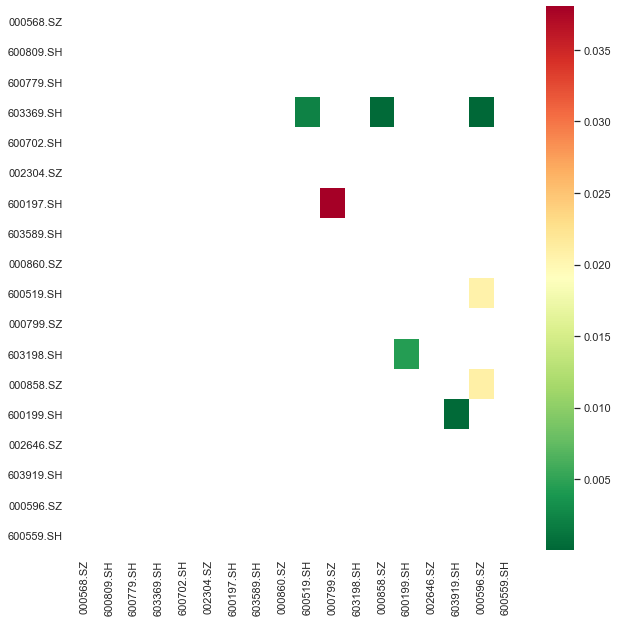

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [5]:
test_pair = pairs[2]
S1 = df[test_pair[0]]
S2 = df[test_pair[1]]
ratios = S1/S2

In [6]:
train_size = int(len(ratios) * .7)
train = ratios[:train_size]
test = ratios[train_size:]

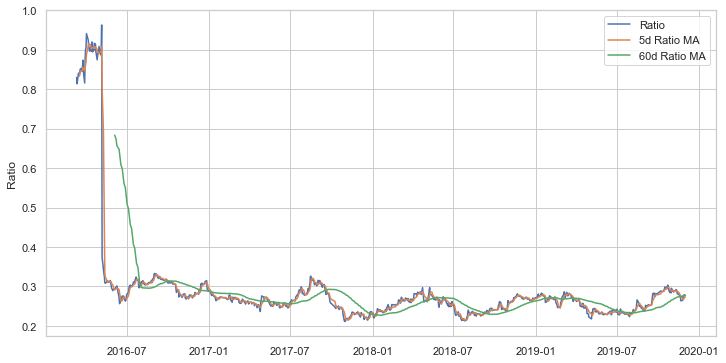

In [7]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

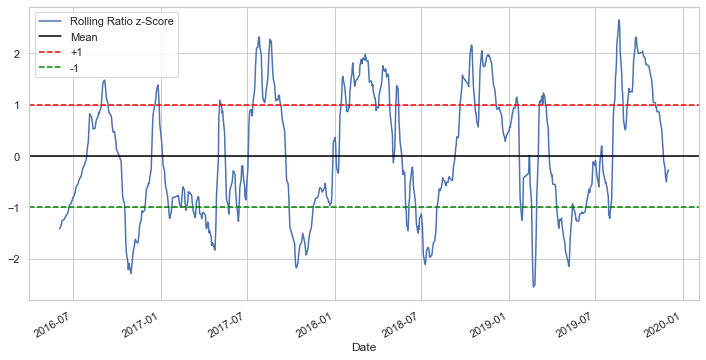

In [8]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

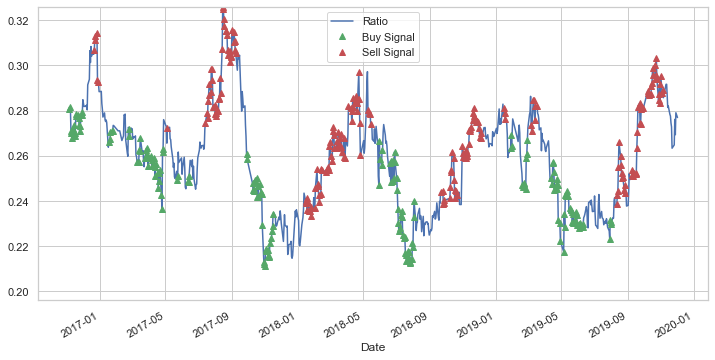

In [23]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios[160:].min(), ratios[160:].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

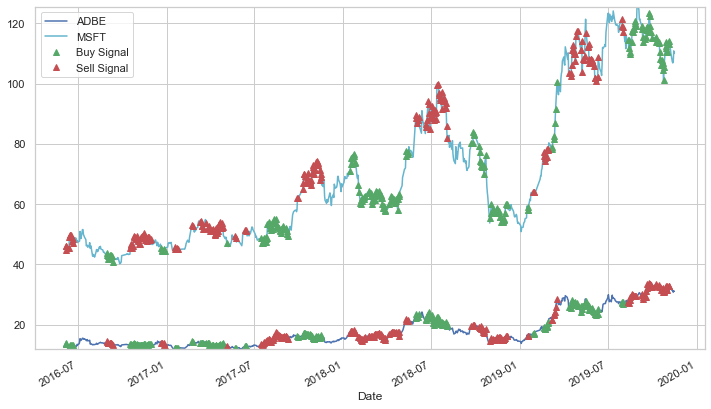

In [10]:
plt.figure(figsize=(12,7))
S1 = df[test_pair[0]].iloc[:900]
S2 = df[test_pair[1]].iloc[:900]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [11]:
def trade(data):
    ratios = data.iloc[:, 0]/data.iloc[:, 1]
    ma1 = ratios.rolling(window=5, center=False).mean()
    ma2 = ratios.rolling(window=60, center=False).mean()
    std = ratios.rolling(window=60, center=False).std()
    data['zscore'] = (ma1 - ma2)/std
    
    data['position_1'] = np.where(data['zscore'] > 1.5, -1, np.nan)
    data['position_1'] = np.where(data['zscore'] < -1.5, 1, data['position_1'])
    data['position_1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_1'])
    
    data['position_1'] = data['position_1'].ffill().fillna(0)
    data['position_2'] = -np.sign(data['position_1'])
    
    data['returns_1'] = (np.log(data.iloc[:, 0] / data.iloc[:, 0].shift(1))).fillna(0)
    data['returns_2'] = (np.log(data.iloc[:, 1] / data.iloc[:, 1].shift(1))).fillna(0)
    data['strategy'] = 0.5*(data['position_1'].shift(1) * data['returns_1']) + 0.5*(data['position_2'].shift(1) * data['returns_2'])
    
    return data

In [12]:
data = trade(df[list(test_pair)].copy())
data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).tail(1)

,returns_1,returns_2,strategy
Date,,,
2021-07-13,2.023001,7.212121,1.05931
